# Approximating the semantic complexity of a sentence

### Hale, John (2006). <em>Uncertainty About the Rest of the Sentence</em>, Cognitive Science 30 (2006), 643–672

"The [entropy reduction hypothesis] ERH might be glossed as saying that a person’s processing difficulty at a word in a sentence is proportional to the number of bits signaled to the person by that word with respect to a probabilistic grammar the person knows."<br>

"The [entropy reduction hypothesis], if correct, would offer just such an explanation. If a person’s difficulty on each word of a sentence is related to the amount of derivational information signaled by that word, then the total difficulty reading a sentence should be the sum of the difficulty on each word."

### Assumptions for the study

We make the simplifying assumption that the Hale's method to measure sentence difficulty (2003b, 2006) can be used to approximate sentential semantic complexity.<br>

Given a word $ w_{i} $ and its conditional entropy $ H(w_{i}) $, its <strong>entropy reduction</strong>, $ ER $, is given by
$$ ER = max(0, H(w_{i-1}) - H(w_{i})) $$

If $ w_{i} $ performs disambiguation relative to the preceding word $ w_{i-1} $, then $ H(w_{i-1}) > H(w_{i}) $ (equivalently, $ H(w_{i}) < H(w_{i-1}) $) and the difference $ H(w_{i-1}) - H(w_{i}) > 0 $. Otherwise, this difference is negative, and by definition, $ ER = 0 $.<br>

For a sentence $ S = \langle x_{1}, \dots, x_{n} \rangle $, its difficulty can be approximated by summing the over the difficulties on each word.

### Methods

To approximate token probabilities, we use <a href="https://huggingface.co/gpt2-large">GPT-2 large</a>, an English language model (LM). It is accessible via the Hugging Face framework.<br>

For tensor manipulation and operations, we use PyTorch.

### Calculation: Sentential semantic complexity

#### Import statements

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import torch
from transformers import PreTrainedTokenizerFast, GPT2TokenizerFast, GPT2LMHeadModel

torch.manual_seed(42) # Seed seed for reproducibility

In [2]:
lm = GPT2LMHeadModel.from_pretrained('gpt2-large')
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2-large')

#### Define sentences

Parallel corpora (```common``` = sentences with commonly appearing adverbs, ```rare``` = sentences with rarely appearing adverbs)

In [3]:
common = [
	'They looked at each other happily.',
	'The experienced doctor performed the operation successfully.',
	'She did not move, continuing to stare at me passionately.',
	'The dogs barked unexpectedly.',
	'The man on the boat waved angrily.',
	'One important person has been continuously absent.',
	'By the swimming pool, the neighbour waited nervously.',
	'It is so easy to be occasionally charitable.',
	'She clings to her marriage desperately.',
	'In this country, racism is spreading constantly.',
	'The little girl screamed and stamped her foot emotionally.',
	'The guests avoided all political discussion carefully.',
	'The day started normally.',
	'She grabbed the microphone stepped onto the stage confidently.',
	'They have been misleading you most unacceptably.',
	'To meet the deadline, the team worked efficiently.',
	'The student studied for the exam carefully.'
]

In [4]:
rare = [
	'They looked at each other amiably.',
	'The experienced doctor performed the operation dexterously.',
	'She did not move, continuing to stare at me belligerently.',
	'The dogs barked ferociously.',
	'The man on the boat waved affably.',
	'One important person has been conspicuously absent.',
	'By the swimming pool, the neighbour waited languidly.',
	'It is so easy to be vicariously charitable.',
	'She clings to her marriage tenaciously.',
	'In this country, racism has been spreading insidiously.',
	'The little girl screamed and stamped her foot petulantly.',
	'The guests avoided all political discussion sedulously.',
	'The day started mundanely.',
	'She grabbed the microphone and stepped onto the stage audaciously.',
	'They have been misleading you most egregiously.',
	'To meet the deadline, the team worked assiduously.',
	'The student studied for the exam sedulously.'
]

#### How to calculate sentence entropies
* <strong>Step 1:</strong> Tokenize sentences, i.e. map each token to an index in the LM's vocabulary.
	* <strong>Step 1.5:</strong> Extract the adverb from the sentence and tokenize it separately from the entire sentence. (Some words like "sedulously" are mapped to more than 1 item in GPT-2's vocabulary. Therefore, we must tokenize the adverb separately from the entire sentence. See: <strong>Note</strong>.)
* <strong>Step 2:</strong> Add \<BOS\> and <\EOS\> tokens to the sequence so that the probabilities we get are properly conditioned on the preceding tokens.
* <strong>Step 3:</strong> Calculate tokens' conditional logits (pre-softmax probabilities) under the LM.
* <strong>Step 4:</strong> Calculate sentential entropy, approximated as the sum of the token surprisals at each time step (token position).

The helper function below defines entropy reduction (ER) as defined in the Assumptions section.

In [5]:
def calc_er(
	token_ids: torch.LongTensor,
	entropy_tensor: torch.FloatTensor,
	tokenizer: PreTrainedTokenizerFast
) -> float:
	"""Calculate the entropy reduction (ER) of a sentence."""
	assert token_ids.size() == entropy_tensor.size()
	assert token_ids[0] == tokenizer.bos_token_id
	assert token_ids[-1] == tokenizer.eos_token_id

	er = 0
	for i in range(1, entropy_tensor.size(0)):
		work = entropy_tensor[i] - entropy_tensor[i-1]
		er += max(0, work)
	return er

##### Common adverb sentences

In [6]:
sent_ents_common = dict()
for sent in common:
	# Step 1
	tokenized = tokenizer(sent)['input_ids']
	# Step 2
	input_ids = torch.tensor([tokenizer.bos_token_id] + tokenized + [tokenizer.eos_token_id])
	# Step 3
	with torch.no_grad():
		outputs = lm(input_ids, labels=input_ids)
	logits = outputs['logits']
	# Step 4
	nlls = -1 * torch.log_softmax(logits, dim=-1) # Token surprisal
	probs = torch.softmax(logits, dim=-1) # Token probability under the LM
	entropies = torch.sum(nlls * probs, dim=-1) # Sequence distribution entropy
	sent_entropy = calc_er(input_ids, entropies, tokenizer) # Sum of all token difficulties
	# Update dictionary
	sent_ents_common[sent_entropy] = sent

In [7]:
print('Summary: Common sentences')

for sent_ent, sent in sent_ents_common.items():
    print(f'{sent_ent.item()}\t{sent}')
print('')

ents_common = torch.round(torch.tensor([ents for ents in sent_ents_common.keys()]), decimals=5)
mean_ents_common = torch.mean(ents_common)
std_ents_common = torch.std(ents_common)
print(f'Mean: {mean_ents_common} bits')
print(f'Standard deviation: {std_ents_common.item()} bits')

Summary: Common sentences
7.267353534698486	They looked at each other happily.
5.7625226974487305	The experienced doctor performed the operation successfully.
10.270366668701172	She did not move, continuing to stare at me passionately.
6.576528072357178	The dogs barked unexpectedly.
9.525788307189941	The man on the boat waved angrily.
9.291593551635742	One important person has been continuously absent.
11.173080444335938	By the swimming pool, the neighbour waited nervously.
11.269996643066406	It is so easy to be occasionally charitable.
10.110099792480469	She clings to her marriage desperately.
10.916854858398438	In this country, racism is spreading constantly.
8.631889343261719	The little girl screamed and stamped her foot emotionally.
6.5859270095825195	The guests avoided all political discussion carefully.
6.226554870605469	The day started normally.
10.163542747497559	She grabbed the microphone stepped onto the stage confidently.
11.181346893310547	They have been misleading you most

##### Rare adverb sentences

In [8]:
sent_ents_rare = dict()
for sent in rare:
	# Step 1
	tokenized = tokenizer(sent)['input_ids']
	# Step 2
	input_ids = torch.tensor([tokenizer.bos_token_id] + tokenized + [tokenizer.eos_token_id])
	# Step 3
	with torch.no_grad():
		outputs = lm(input_ids, labels=input_ids)
	# Step 4
	logits = outputs['logits']
	logits_shifted = logits[..., :-1, :].contiguous()
	# Step 5
	nlls = -1 * torch.log_softmax(logits, dim=-1) # Token surprisal
	probs = torch.softmax(logits, dim=-1) # Token probability under the LM
	entropies = torch.sum(nlls * probs, dim=-1) # Sequence distribution entropy
	sent_entropy = calc_er(input_ids, entropies, tokenizer) # Sentence entropy = sum over all tokens
	# Update dictionary
	sent_ents_rare[sent_entropy] = sent

In [9]:
print('Summary: Rare sentences')

for sent_ent, sent in sent_ents_rare.items():
    print(f'{sent_ent.item()}\t{sent}')
print('')

ents_rare = torch.tensor([ents for ents in sent_ents_rare.keys()])
print(f'Mean: {torch.mean(ents_rare)}')
print(f'Standard deviation: {torch.std(ents_rare)}')

Summary: Rare sentences
8.65108585357666	They looked at each other amiably.
8.50815200805664	The experienced doctor performed the operation dexterously.
12.047250747680664	She did not move, continuing to stare at me belligerently.
9.646944046020508	The dogs barked ferociously.
9.96815299987793	The man on the boat waved affably.
10.107120513916016	One important person has been conspicuously absent.
13.756447792053223	By the swimming pool, the neighbour waited languidly.
16.987733840942383	It is so easy to be vicariously charitable.
11.898886680603027	She clings to her marriage tenaciously.
13.954389572143555	In this country, racism has been spreading insidiously.
11.3812255859375	The little girl screamed and stamped her foot petulantly.
7.7398481369018555	The guests avoided all political discussion sedulously.
7.6264801025390625	The day started mundanely.
14.73045539855957	She grabbed the microphone and stepped onto the stage audaciously.
8.505223274230957	They have been misleading you 

#### Distribution of sentence entropies: KDE plot

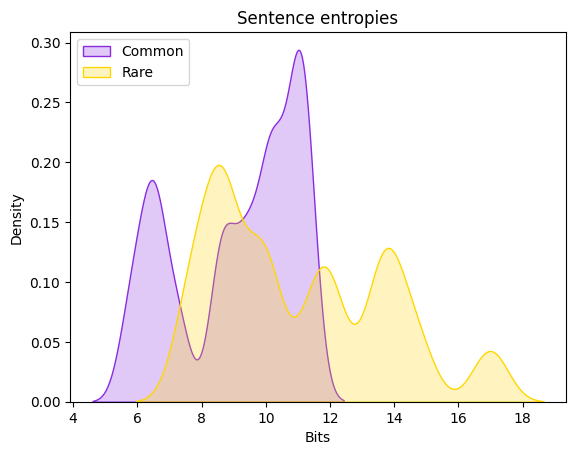

In [10]:
fig, ax = plt.subplots()

# Common
ents_common = torch.tensor([ents for ents in sent_ents_common.keys()])
sns.kdeplot(
    data=ents_common,
    ax=ax,
    bw_method=0.2,
    color='blueviolet',
    fill=True,
    label='Common'
);

# Rare
ents_rare = torch.tensor([ents for ents in sent_ents_rare.keys()])
sns.kdeplot(
    data=ents_rare,
    ax=ax,
    bw_method=0.2,
    color='gold',
    fill=True,
    label='Rare'
);

# Plot params
ax.set(title='Sentence Complexity (ERs)')
ax.legend(loc='upper left')
ax.set(xlabel='Bits');